In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COVID Detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/COVID Detection


### Import all models and other necessary things

In [5]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [6]:

IMAGE_SIZE = [224, 224] 


epochs = 500
batch_size = 32

covid_path = '/content/drive/My Drive/COVID Detection/Chest_COVID'
noncovid_path = '/content/drive/My Drive/COVID Detection/Chest_NonCOVID'

covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

### Fetch Images and Class Labels from Files

In [7]:

covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

### Visualize First 40 Images from Data set

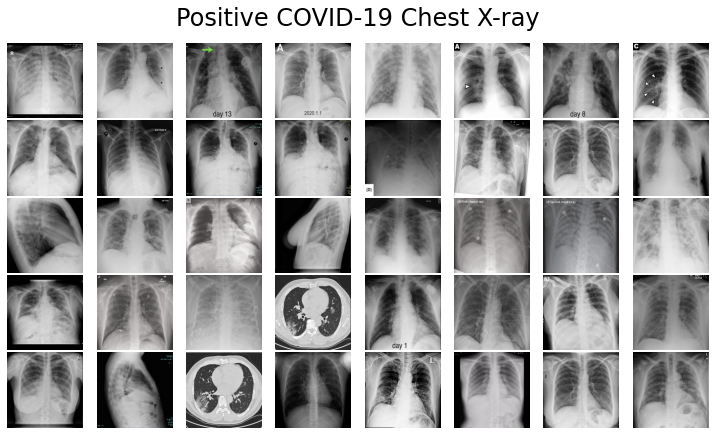

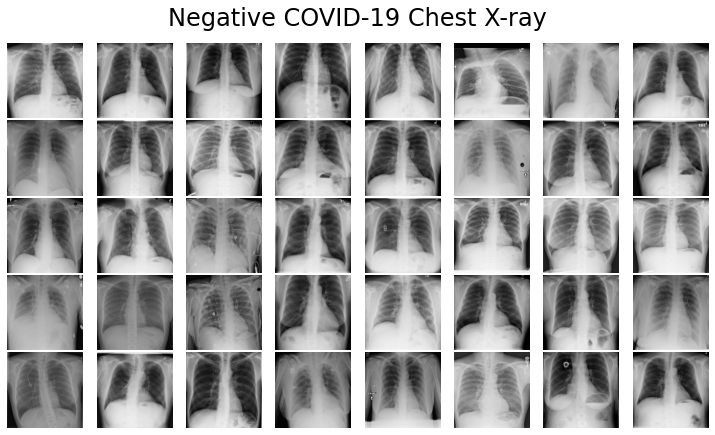

In [8]:

def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

### **Normalization**



In [9]:

covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical


covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)


y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

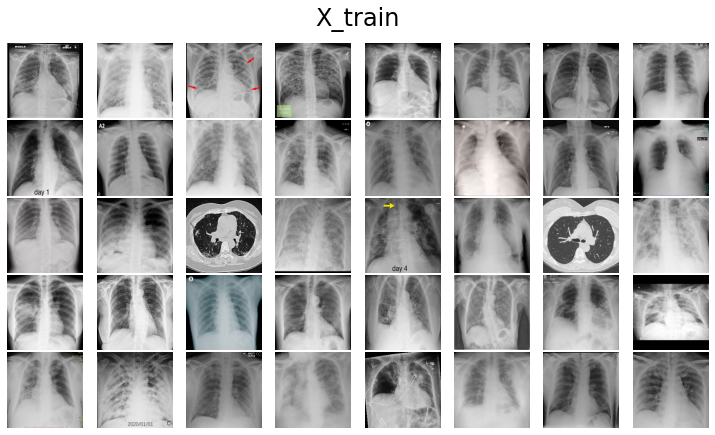

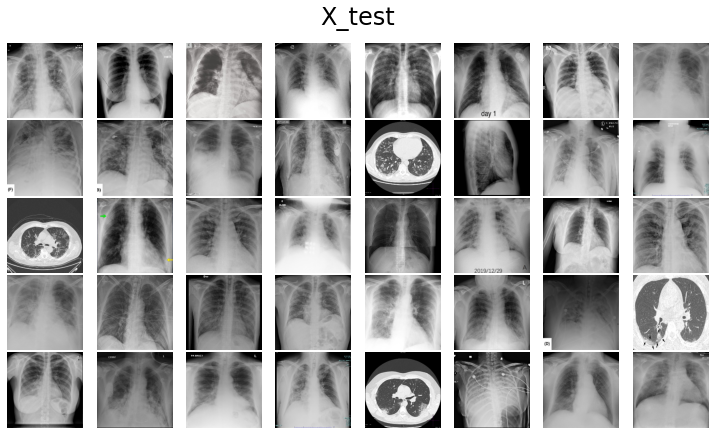

In [11]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')


### **Building model (Inception v3)**

In [ ]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### **Training the model**

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
23/23 [==============================] - 18s 374ms/step - loss: 8.4418 - accuracy: 0.5378 - val_loss: 1.3086 - val_accuracy: 0.8032
Epoch 2/500
23/23 [==============================] - 7s 314ms/step - loss: 1.6699 - accuracy: 0.8304 - val_loss: 1.1262 - val_accuracy: 0.7979
Epoch 3/500
23/23 [==============================] - 7s 308ms/step - loss: 1.0313 - accuracy: 0.8402 - val_loss: 0.7588 - val_accuracy: 0.8138
Epoch 4/500
23/23 [==============================] - 7s 302ms/step - loss: 1.0652 - accuracy: 0.8283 - val_loss: 0.4298 - val_accuracy: 0.8830
Epoch 5/500
23/23 [==============================] - 7s 302ms/step - loss: 0.6410 - accuracy: 0.8755 - val_loss: 1.3724 - val_accuracy: 0.7447
Epoch 6/500
23/23 [==============================] - 7s 300ms/step - loss: 0.8498 - accuracy: 0.8459 - val_loss: 0.4770 - val_accuracy: 0.8404
Epoch 7/500
23/23 [==============================] - 7s 302ms/step - loss: 0.6852 - accuracy: 0.8575 - val_loss: 0.4736 - val_accuracy: 0.888

In [ ]:
model.save('inceptionv3_chest.h5')

In [ ]:
model.save_weights('inceptionv3_chest.hdf5')

In [22]:
model = load_model('inceptionv3_chest.h5')
model_json = model.to_json()

with open("model.json", "w") as json_file:

    json_file.write(model_json)

### **Making Predicions**

In [14]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

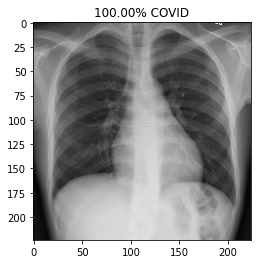

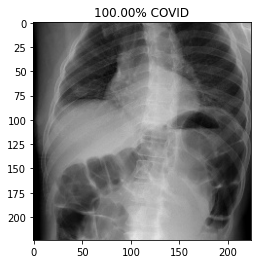

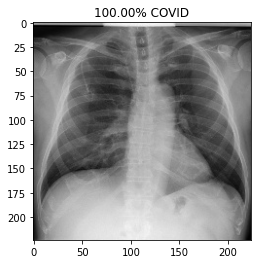

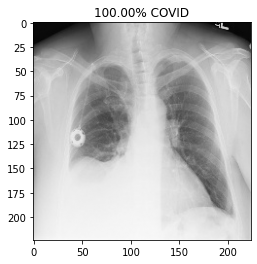

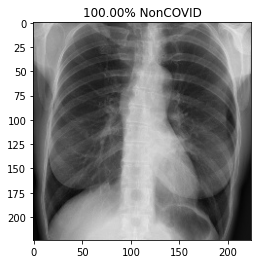

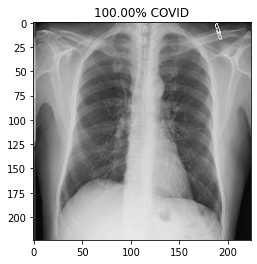

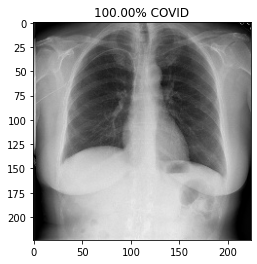

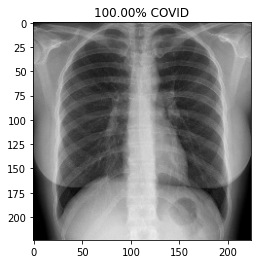

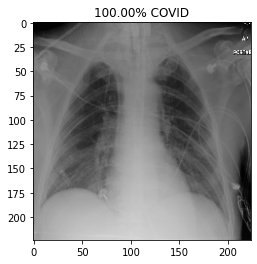

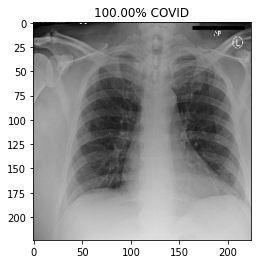

In [15]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [17]:

y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

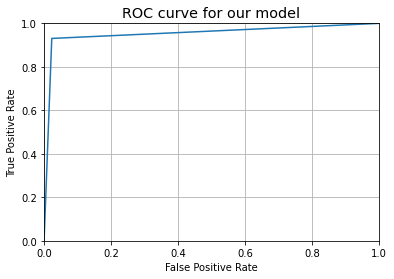

In [18]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


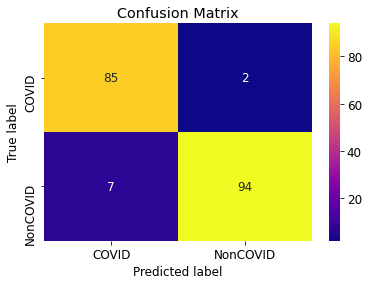

Confusion Matrix with Normalized Values


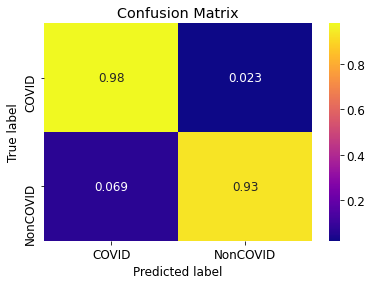

In [19]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [1]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

NameError: ignored

### **Accuracy and Loss Plots**

In [21]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_accuracy.png')
plt.show()


NameError: ignored

<Figure size 720x720 with 0 Axes>

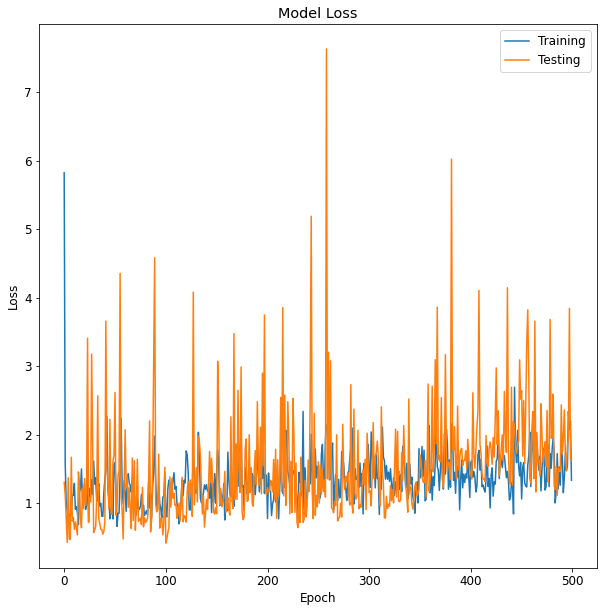

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_loss.png')
plt.show()

In [ ]:
json_file = open('models/model4-50epochs.json','r')

loaded_model_json = json_file.read()

json_file.close()



# use Keras model_from_json to make a loaded model



loaded_model = model_from_json(loaded_model_json)



# load weights into new model



loaded_model.load_weights("models/model4-50epochs.h5")

# print("Loaded Model from disk")



# compile and evaluate loaded model

loaded_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

